In [11]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

In [1]:
import warnings
from tqdm import tqdm

import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, train_test_split, KFold
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

import optuna
from functools import partial

warnings.filterwarnings('ignore')

In [3]:
df_train = pd.read_csv('../data/train_df1.csv')
df_test = pd.read_csv('../data/test_df1.csv')

In [4]:
def RMSE(y, y_pred):
    rmse = mean_squared_error(y, y_pred) ** 0.5
    return rmse

In [ ]:
models = []
scores = []
for idx, model in enumerate([low_model_xgb, low_model_lgb]):
    model_name, mean_score = print_rmse_score(model)
    models.append(model_name)
    scores.append(mean_score)

In [5]:
train_size = int(df_train.shape[0] * 0.8)
test_size = df_train.shape[0] - train_size
dataset = df_train.copy()
train_dataset, valid_dataset = dataset.iloc[:train_size], dataset.iloc[:test_size]

X_train = train_dataset.drop(columns=['target'], axis=1)
y_train = train_dataset['target']

X_val = valid_dataset.drop(columns=['target'], axis=1)
y_val = valid_dataset['target']

print(train_size, test_size)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

895056 223764
(895056, 52) (223764, 52) (895056,) (223764,)


In [582]:
def optimizer(trial, X, y, K):
    # 조절할 hyper-parameter 조합을 적어줍니다.
    params = {
        'max_depth' : trial.suggest_int('max_depth', 3, 20),
        'n_estimators' : trial.suggest_int('n_estimators', 50, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.1, log = True),
        'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
        'colsample_bytree' : trial.suggest_float('colsample_bytree', 0.3, 0.8),
        'colsample_bynode' : trial.suggest_float('colsample_bynode', 0.5, 1.0),
        'reg_lambda' : trial.suggest_float('reg_lambda', 0.5, 20.0),
        'gamma': trial.suggest_float('gamma', 1e-4, 1.0),
    }

    model = XGBRegressor(**params, tree_method='gpu_hist')
    tscv = TimeSeriesSplit(n_splits=K)
    losses = []

    for train_idx, val_idx in tscv.split(X, y):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]

        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]

        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        loss = RMSE(y_val, preds)
        losses.append(loss)

    # scores = cross_val_score(model, X, y, cv=tscv, scoring='neg_mean_absolute_error')
    return np.mean(losses)

In [583]:
K = 5   # Kfold 수
# optimizer 함수에 parameter passing을 하고 싶은 경우.
opt_func = partial(optimizer, X=X_train, y=y_train, K=K)

study = optuna.create_study(direction="minimize") # 최소/최대 어느 방향의 최적값을 구할 건지.
study.optimize(opt_func, n_trials=50)

[I 2024-01-25 01:46:30,580] A new study created in memory with name: no-name-44774fbe-28e2-4922-8ef3-5b61bb6ce8c9
[I 2024-01-25 01:46:57,594] Trial 0 finished with value: 0.3064215853798745 and parameters: {'max_depth': 10, 'n_estimators': 477, 'learning_rate': 0.002042817321327971, 'subsample': 0.4154842347442941, 'colsample_bytree': 0.4906826234257438, 'colsample_bynode': 0.8634411862528837, 'reg_lambda': 19.72687484382646, 'gamma': 0.920238156848769}. Best is trial 0 with value: 0.3064215853798745.
[I 2024-01-25 01:47:03,576] Trial 1 finished with value: 0.4722313045085098 and parameters: {'max_depth': 5, 'n_estimators': 357, 'learning_rate': 0.001082028787084981, 'subsample': 0.47541549704255276, 'colsample_bytree': 0.7186253111388348, 'colsample_bynode': 0.9228533078344918, 'reg_lambda': 14.271738308004274, 'gamma': 0.5490295722417371}. Best is trial 0 with value: 0.3064215853798745.
[I 2024-01-25 01:47:44,493] Trial 2 finished with value: 0.5883417392890121 and parameters: {'max_

In [ ]:
best_params = study.best_params
best_params

In [8]:
best_params = {'max_depth': 14,
 'n_estimators': 877,
 'learning_rate': 0.03048514437462807,
 'subsample': 0.4957514121235592,
 'colsample_bytree': 0.5836777710462664,
 'colsample_bynode': 0.5364149585483765,
 'reg_lambda': 12.540758449155891,
 'gamma': 0.024147649062768006}

In [9]:
best_model = XGBRegressor(**best_params, random_state=42, tree_method='gpu_hist')
best_model.fit(X_train, y_train)
pred_train = best_model.predict(X_train)
pred_val = best_model.predict(X_val)

print(f'log train RMSE: {np.sqrt(mean_squared_error(y_train, pred_train))}')
print(f'train RMSE: {np.sqrt(mean_squared_error(np.expm1(y_train), np.expm1(pred_train)))}')
print(f'log val RMSE: {np.sqrt(mean_squared_error(y_val, pred_val))}')
print(f'val RMSE: {np.sqrt(mean_squared_error(np.expm1(y_val), np.expm1(pred_val)))}')

log train RMSE: 0.053999866092569834
train RMSE: 4590.995530475831
log val RMSE: 0.05895877584762837
val RMSE: 4652.978569995074


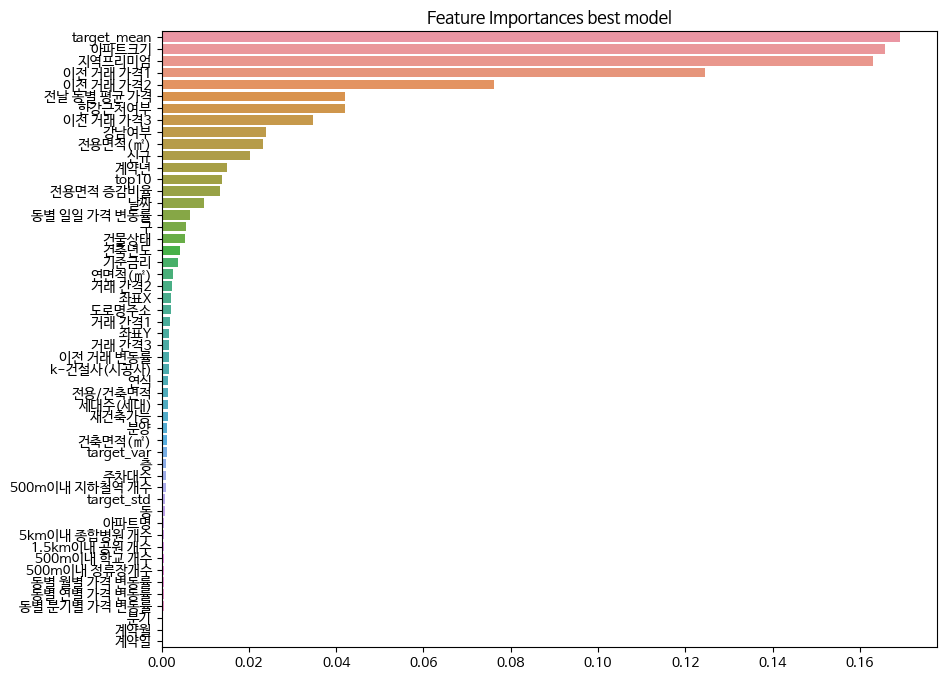

In [12]:
importances = pd.Series(best_model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances best model")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [13]:
# Validation dataset에 target과 pred 값을 채워주도록 하겠습니다.
X_val['target'] = y_val
X_val['pred'] = pred_val

In [14]:
# Squared_error를 계산하는 함수를 정의하겠습니다.
def calculate_se(target, pred):
    squared_errors = (target - pred) ** 2
    return squared_errors

# RMSE 계산
squared_errors = calculate_se(X_val['target'], X_val['pred'])
X_val['error'] = squared_errors

In [15]:
X_val_sort = X_val.sort_values(by='error', ascending=False)    # 내림차순 sorting#

In [16]:
X_val_sort.head()

,아파트명,전용면적(㎡),계약일,층,건축년도,세대수(세대),k-건설사(시공사),연면적(㎡),건축면적(㎡),주차대수,...,target_mean,target_std,target_var,전용/건축면적,신규,분양,분기,target,pred,error
160743,3363,114.76,11,10,1999,203.000000,311,24032.800000,1521.1300,183.00,...,9.902913,0.228941,0.052414,0.075444,0,0,3,7.003974,9.062001,4.235476
136612,338,50.67,27,4,1982,60.000000,66,2335.800000,467.1600,5881.00,...,11.217612,0.013507,0.000182,0.108464,0,0,2,9.210440,10.655368,2.087815
97308,3617,28.79,7,5,1984,100.558741,93,5676.846042,493.7418,341.67,...,11.011005,0.153202,0.023471,0.058310,0,0,4,8.517393,9.892120,1.889875
134268,336,41.98,2,2,1982,5040.000000,174,240629.000000,172371.0000,2.00,...,11.417171,0.331774,0.110074,0.000244,0,0,3,8.922792,10.195350,1.619404
186358,2238,55.62,4,6,1980,74.600451,93,1234.091800,195.4946,132.63,...,10.866153,0.212527,0.045168,0.284509,0,0,2,8.699681,9.960864,1.590582


In [17]:
X_val_sort_top100 = X_val.sort_values(by='error', ascending=False).head(4500)        # 예측을 잘 하지못한 top 100개의 data
X_val_sort_tail100 = X_val.sort_values(by='error', ascending=False).tail(4500)       # 예측을 잘한 top 100개의 data

In [18]:
# 해석을 위해 레이블인코딩 된 변수를 복원해줍니다.
error_top100 = X_val_sort_top100.copy()
for column in X_val.columns :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
    error_top100[column] = X_val_sort_top100[column]

best_top100 = X_val_sort_tail100.copy()
for column in X_val.columns :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
    best_top100[column] = X_val_sort_tail100[column]

In [21]:
np.sqrt(mean_squared_error(np.expm1(best_top100['target']), np.expm1(best_top100['pred'])))

49.03468909667031

In [22]:
np.sqrt(mean_squared_error(np.expm1(error_top100['target']), np.expm1(error_top100['pred'])))

17613.184761883105

<Axes: xlabel='target', ylabel='Count'>

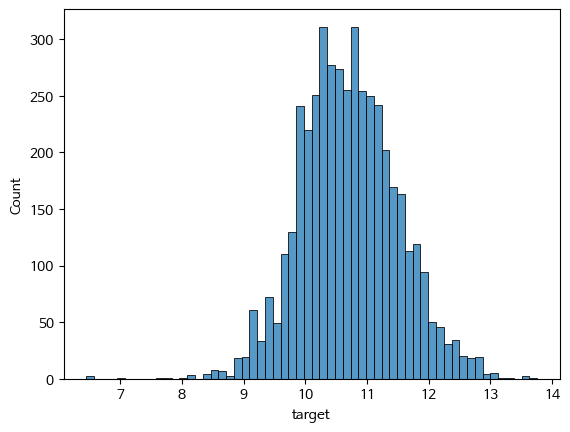

In [23]:
sns.histplot(data = error_top100, x='target')

<Axes: xlabel='pred', ylabel='Count'>

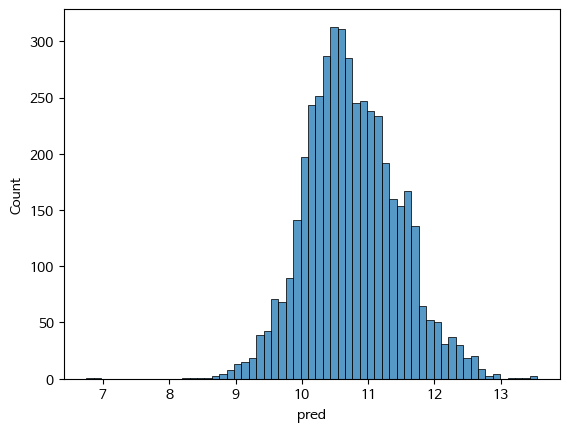

In [24]:
sns.histplot(data = error_top100, x='pred')

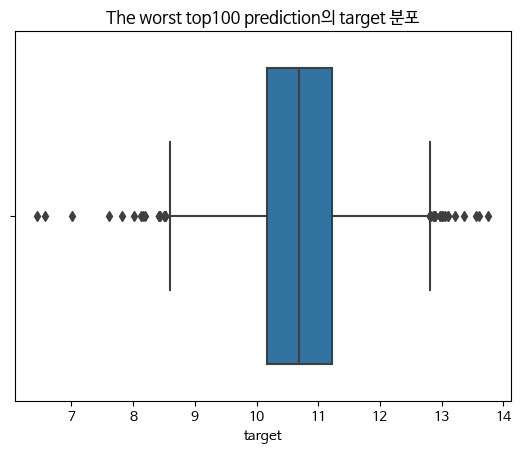

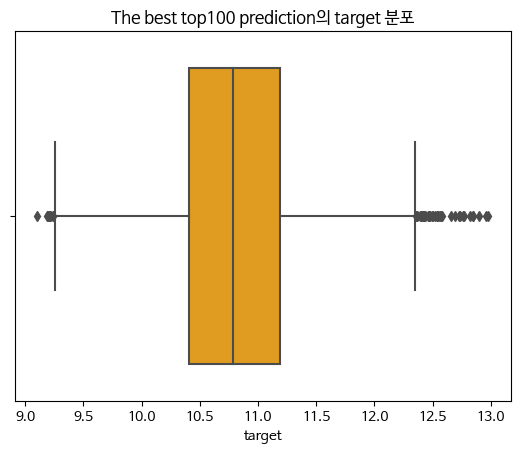

In [25]:
sns.boxplot(data = error_top100, x='target')
plt.title('The worst top100 prediction의 target 분포')
plt.show()

sns.boxplot(data = best_top100, x='target', color='orange')
plt.title('The best top100 prediction의 target 분포')
plt.show()

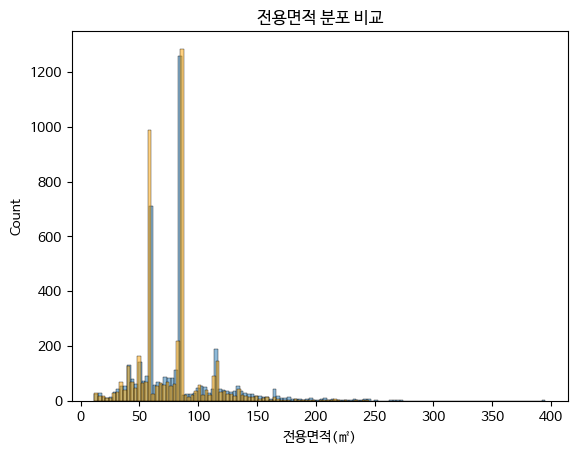

In [26]:
sns.histplot(data = error_top100, x='전용면적(㎡)', alpha=0.5)
sns.histplot(data = best_top100, x='전용면적(㎡)', color='orange', alpha=0.5)
plt.title('전용면적 분포 비교')
plt.show()

In [215]:
temp_a = df_train[df_train['target'] > 0.3 * 1e6]
temp_b = df_train[df_train['target'] <= 0.3 * 1e6]

<Axes: xlabel='좌표X', ylabel='좌표Y'>

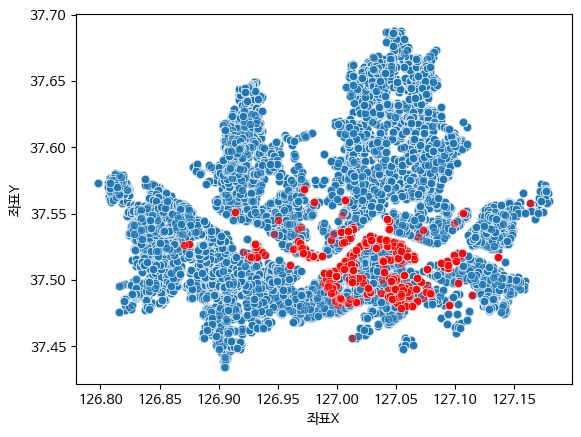

In [216]:
sns.scatterplot(data=temp_b, x='좌표X', y='좌표Y', alpha=0.5)
sns.scatterplot(data=temp_a, x='좌표X', y='좌표Y', color='red', alpha=0.5)

In [ ]:
pred = np.expm1(best_model.predict(df_test))
preds_df = pd.DataFrame(pred.astype(int), columns=["target"])
preds_df.to_csv('output.csv', index=False)